### Author: Rosy Chen

# Train Data

In [1]:
data = helper.Data(train_data_path=FILEPATH)
orig_df = data.update_and_get_train_df("20150121", backward_dayCount = 1, train_data_count = 100)
df = orig_df.copy()

  Using cached urllib3-2.0.5-py3-none-any.whl (123 kB)
INFO: pip is looking at multiple versions of qtpy to determine which version is compatible with other requirements. This could take a while.
  Using cached QtPy-2.3.0-py3-none-any.whl (83 kB)
INFO: pip is looking at multiple versions of qtconsole to determine which version is compatible with other requirements. This could take a while.
  Using cached qtconsole-5.4.0-py3-none-any.whl (121 kB)
INFO: pip is looking at multiple versions of pyzmq to determine which version is compatible with other requirements. This could take a while.
  Using cached pyzmq-25.0.0-cp310-cp310-macosx_10_15_universal2.whl (1.8 MB)
INFO: pip is looking at multiple versions of pyyaml to determine which version is compatible with other requirements. This could take a while.
  Using cached PyYAML-6.0-cp310-cp310-macosx_11_0_arm64.whl (173 kB)
INFO: pip is looking at multiple versions of pytz to determine which version is compatible with other requirements. Thi

In [6]:
### EDA

#### Machine

In [7]:
# User Specific Constants:
USER = "ROSY"
FILE_PATH = consts.PATH_MAP[USER]

df = removed_massive_null(df, 20)

In [8]:
def filter_duplicatations(df, axis: int) -> 'DataFrame':
    use_df = df if axis == 0 else df.T
    answer_df = use_df.drop_duplicates()
    return answer_df if axis == 0 else answer_df.T

df = filter_duplicatations(df, axis = consts.COL)

In [9]:
def transform_col(df, col_name: str, transform_func: 'Function') -> None:
    df.loc[:, col_name] = df[col_name].apply(transform_func); return
    
transform_col(df, consts.RESPONSE_NAME, lambda x: 1 if x > 0 else -1)

In [8]:
def is_responseVal_unbalanced(df: 'DataFrame', response_col_name: str) -> bool:
    freq_map: dict = df[response_col_name].value_counts().to_dict()
    print(freq_map)
    sorted_by_val_keys = sorted(freq_map, key = freq_map.get, reverse = True)
    
    total_count = sum(freq_map.values()); major_val_count = 0
    for key in sorted_by_val_keys:
        major_val_count += freq_map[key]
        if major_val_count > 0.5 * total_count: break
    
    distribution_plot(df, [consts.RESPONSE_NAME], bins = 10)
    return major_val_count >= 0.7 * total_count

   rrirpnxm_nt_0  rrirpnxm_lst15_0  rrirpnxm_lsthrx15_0  rrirpnxm_toxhr_0  \
0       0.000000          0.000000             0.000000          0.000000   
1      -0.003448          0.001921             0.001569         -0.013866   
2       0.000000         -0.002830            -0.001450          0.004245   
3       0.000000          0.000000             0.000000          0.000000   
4      -0.001338          0.005082            -0.000502         -0.010742   

   relvol_nt_0  relvol_lst15_0  relvol_lsthrx15_0  relvol_toxhr_0   tonight  
0     0.000000        0.000000           0.000000        0.000000 -0.000073  
1     0.969491        1.051498           1.040871        2.309224 -0.004306  
2    -0.771546       -0.285846           2.607047        1.721344  0.004177  
3     0.000000        0.000000           0.000000        0.000000 -0.000073  
4    -0.931449       -0.178881          -0.648302        0.117725 -0.007763  


{-1.0: 15098, 1.0: 12763}


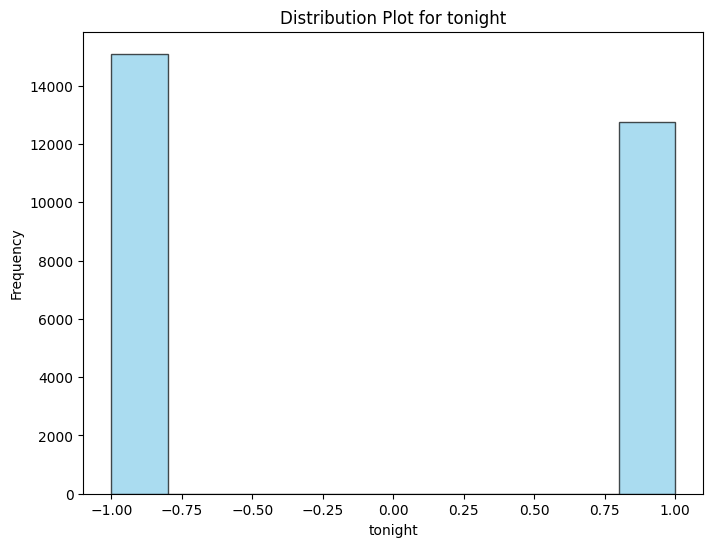

False

In [11]:
is_data_unbalanced = is_responseVal_unbalanced(df, consts.RESPONSE_NAME)
is_data_unbalanced

#### Human

In [10]:
categorical_columns = (df.dtypes == "object")
categorical_columns = np.array(categorical_columns[categorical_columns].index)
len(categorical_columns)

0

In [13]:
df.dtypes.value_counts()

float64    246
Name: count, dtype: int64

# Test Data

#### Make sure test data has similar features to train data

In [15]:
test_df = data.update_and_get_test_df(data_path=FILEPATH, start_date="20150121")[0]
test_df = test_df[df.columns] # TODO: THIS IS VERY IMPORTANT
transform_col(test_df, consts.RESPONSE_NAME, lambda x: 1 if x > 0 else -1)

Getting files from 2015-01-21 00:00:00 to 2015-01-21 00:00:00, inclusive.
Filtered File Dates: ['data.20150121_1200']



# Save

In [16]:
def save_to_csv(df, name, is_train = True):
    directory = "train_data" if is_train else "test_data"
    df.to_csv(f"/Users/hoangchu/Downloads/Clinic/Clinic/data/cleaned_data/{directory}/{name}.csv", index = False)

In [17]:
save_to_csv(df, "train")
save_to_csv(test_df, "test", False)